In [1]:
from collections import Counter
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, make_scorer
from sklearn.metrics import auc, precision_recall_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, ClusterCentroids
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt
import missingno
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import warnings
warnings.filterwarnings('ignore')

## EDA & Feature Engineering

In [2]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


<AxesSubplot:>

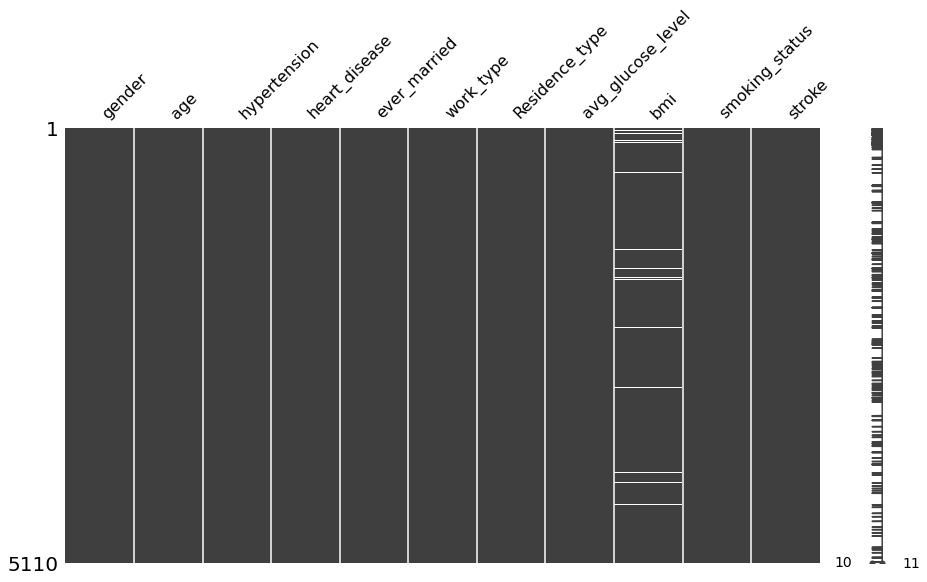

In [3]:
data.drop('id', axis=1, inplace=True)
missingno.matrix(data, figsize = (15,8))

I think I have plenty of data even if I drop missing ones, but let's take a closer look.

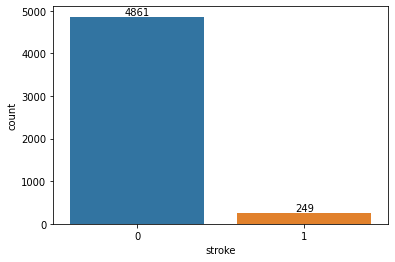

In [4]:
fig, ax = plt.subplots(1,1)
sns.countplot(x='stroke', ax=ax, data=data)
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 5), 
                   textcoords = 'offset points')

Dataset is seriously unbalaced; less than 5 percent of the data are the patients with stroke.

In [5]:
data.isna().sum() / len(data)

gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  0.039335
smoking_status       0.000000
stroke               0.000000
dtype: float64

About 4 percent of data has missing values.

In [6]:
total = len(data)
stroke = len(data[data['stroke'] == 1])
missing = data['bmi'].isna().sum()
missing_stroke = len(data[(data['bmi'].isna()) & (data['stroke'] == 1)])

print('Stroke / Total data: ', stroke / total)
print('Missing data(Stroke) / Missing data: ', missing_stroke / missing)
print('Missing data(Stroke) / Stroke: ', missing_stroke / stroke)
print('(Stroke - Missing data(Stroke)) / (Total - Stroke): ', (stroke - missing_stroke) / (total - missing))

Stroke / Total data:  0.0487279843444227
Missing data(Stroke) / Missing data:  0.19900497512437812
Missing data(Stroke) / Stroke:  0.1606425702811245
(Stroke - Missing data(Stroke)) / (Total - Stroke):  0.04257486249745366


In total data, patient who had stroke are 5%, but in missing data, there are 20%. If I drop missing values, I'll lose 16% of people who had stroke, so I should consider keeping the data. Let's see if we can fill missing bmi values with other features.

<AxesSubplot:>

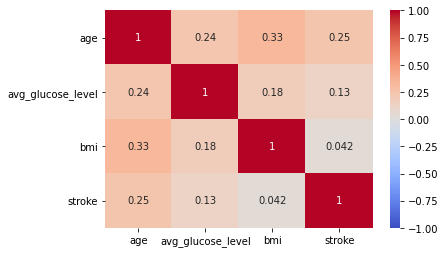

In [7]:
num_data = data[['age', 'avg_glucose_level', 'bmi', 'stroke']]
sns.heatmap(num_data.corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True)

It's hard to replace bmi with age or average glucose level because there aren't any strong relations. 

<AxesSubplot:xlabel='bmi', ylabel='Count'>

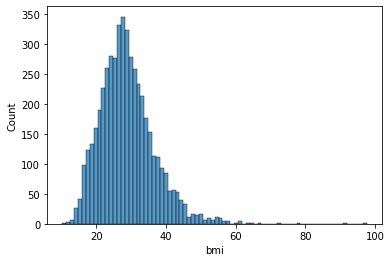

In [8]:
sns.histplot(x='bmi', data=data)

I can drop the missing values or fill it with median. I tried both, and filling with median value yielded better result.

In [9]:
#data.dropna(inplace=True)
median = data['bmi'].median()
data.fillna(median, axis=1, inplace=True)
data.reset_index(drop=True, inplace=True)
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


<AxesSubplot:xlabel='age', ylabel='avg_glucose_level'>

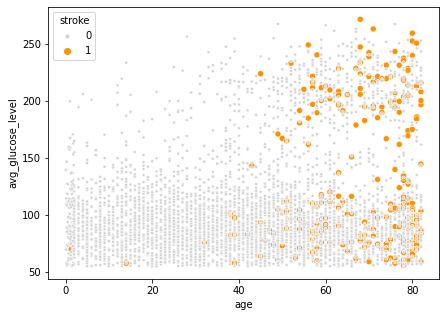

In [10]:
plt.figure(figsize=(7,5))
sns.scatterplot(x='age', y='avg_glucose_level', hue='stroke', style='stroke', markers=['.', 'o'], 
                palette=['#d3d3d3','#ff9201'], alpha=1, data=data)

People had stroke are prominent in upper right side of the plot. I'll isolate the people with age over 50 and glucose over 150.

In [11]:
data['age50_and_glucose150'] = ((data['age'] >= 50) & (data['avg_glucose_level'] >= 150))
neg_data = data[data['stroke']==0]
pos_data = data[data['stroke']==1]

<AxesSubplot:xlabel='stroke', ylabel='count'>

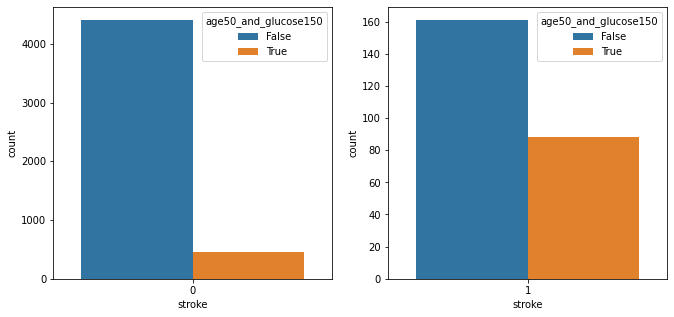

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(11,5))
sns.countplot(x='stroke', hue='age50_and_glucose150', ax=axes[0], data=neg_data)
sns.countplot(x='stroke', hue='age50_and_glucose150', ax=axes[1], data=pos_data)

I added new feature: whether if the person has age over 50 and glucose level over 150. Adding this new feature actually improved the model.

<AxesSubplot:xlabel='stroke', ylabel='count'>

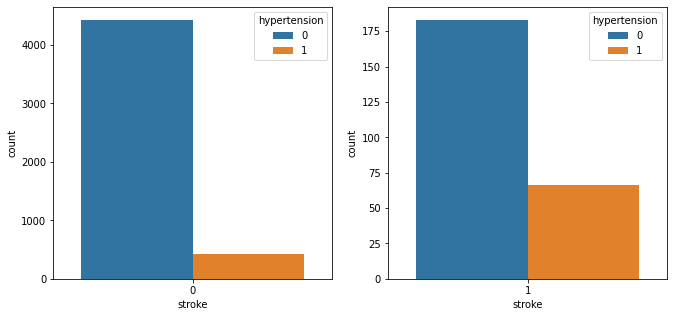

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(11,5))
sns.countplot(x='stroke', hue='hypertension', ax=axes[0], data=neg_data)
sns.countplot(x='stroke', hue='hypertension', ax=axes[1], data=pos_data)

<AxesSubplot:xlabel='stroke', ylabel='count'>

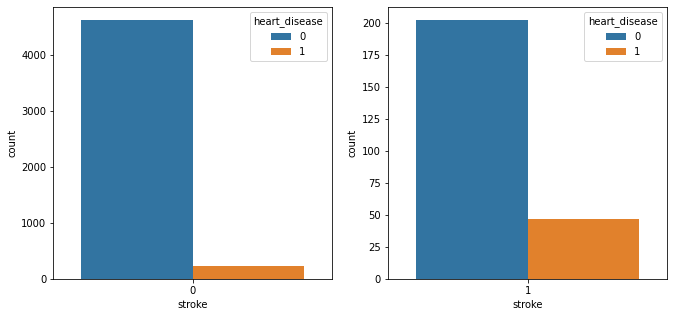

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(11,5))
sns.countplot(x='stroke', hue='heart_disease', ax=axes[0], data=neg_data)
sns.countplot(x='stroke', hue='heart_disease', ax=axes[1], data=pos_data)

People who ever had hypertension or heart disease are more prone to stroke.

<AxesSubplot:xlabel='stroke', ylabel='count'>

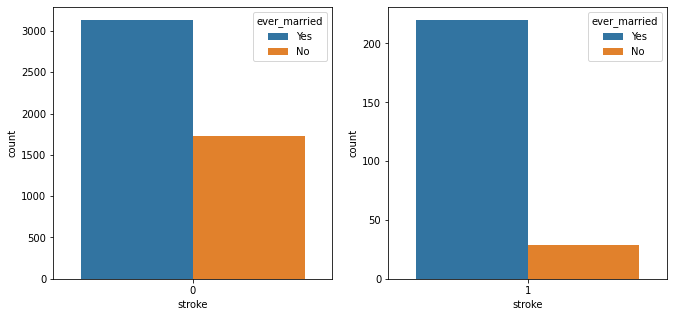

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(11,5))
sns.countplot(x='stroke', hue='ever_married', hue_order=['Yes', 'No'], ax=axes[0], data=neg_data)
sns.countplot(x='stroke', hue='ever_married', ax=axes[1], data=pos_data)

Here's an interesting fact: people that never got married are less likely to have stroke. 

<AxesSubplot:xlabel='stroke', ylabel='count'>

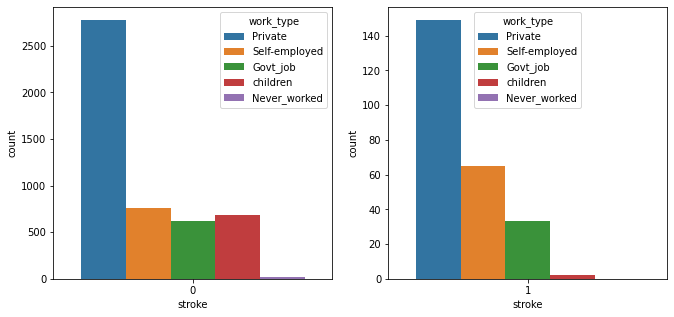

In [16]:
hue_order = data['work_type'].unique()
fig, axes = plt.subplots(1, 2, figsize=(11,5))
sns.countplot(x='stroke', hue='work_type', hue_order=hue_order, ax=axes[0], data=neg_data)
sns.countplot(x='stroke', hue='work_type', hue_order=hue_order, ax=axes[1], data=pos_data)

<AxesSubplot:xlabel='stroke', ylabel='count'>

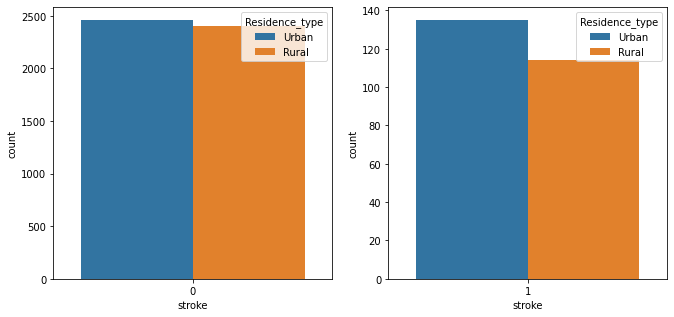

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(11,5))
sns.countplot(x='stroke', hue='Residence_type', hue_order=['Urban', 'Rural'], ax=axes[0], data=neg_data)
sns.countplot(x='stroke', hue='Residence_type', ax=axes[1], data=pos_data)

<AxesSubplot:xlabel='stroke', ylabel='count'>

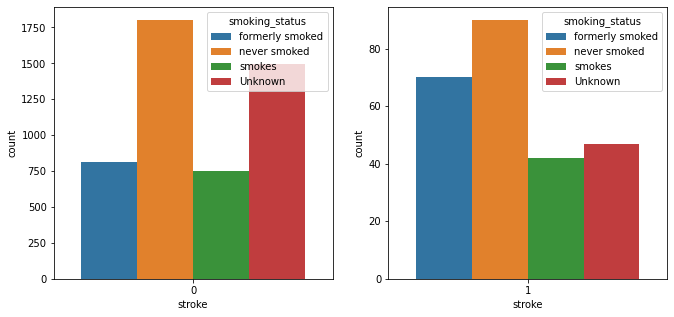

In [18]:
hue_order = data['smoking_status'].unique()
fig, axes = plt.subplots(1, 2, figsize=(11,5))
sns.countplot(x='stroke', hue='smoking_status', hue_order=hue_order, ax=axes[0], data=neg_data)
sns.countplot(x='stroke', hue='smoking_status', hue_order=hue_order, ax=axes[1], data=pos_data)

In [19]:
def grouping(col_name, group_name, n_group=10):
    temp = pd.qcut(data[col_name], n_group)
    data[group_name] = 0
    group_label = []
    
    for i in temp.unique():
        temp1, temp2 = str(i).strip('(],').split(', ')
        group_label.append([float(temp1), float(temp2)])
    group_label = sorted(group_label, key=lambda x: x[0])
    
    for i in range(n_group):
        if i == 0:
            data.loc[data[col_name] <= group_label[i][0], group_name] = i
        elif i == n_group-1:
            data.loc[data[col_name] > group_label[i][0], group_name] = i
        else:
            data.loc[(data[col_name] > group_label[i][0]) & (
                data[col_name] <= group_label[i][1]), group_name] = i

In [20]:
grouping('age', 'Agroup')
grouping('bmi', 'Bgroup')
grouping('avg_glucose_level', 'Ggroup')

I tried converting numerical data into categorical data, but it didn't improve the model, so I won't use these features.

In [22]:
dfl = pd.DataFrame()

label_col = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type',
             'Residence_type', 'age50_and_glucose150']
    
dfl[label_col] = data[label_col]
dfl_enc = dfl.apply(LabelEncoder().fit_transform)
dfl_enc[['age', 'bmi', 'avg_glucose_level']] = data[['age', 'bmi', 'avg_glucose_level']]
dfl_enc

,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,age50_and_glucose150,age,bmi,avg_glucose_level
0,1,0,1,1,2,1,1,67.0,36.6,228.69
1,0,0,0,1,3,0,1,61.0,28.1,202.21
2,1,0,1,1,2,0,0,80.0,32.5,105.92
3,0,0,0,1,2,1,0,49.0,34.4,171.23
4,0,1,0,1,3,0,1,79.0,24.0,174.12
...,...,...,...,...,...,...,...,...,...,...
5105,0,1,0,1,2,1,0,80.0,28.1,83.75
5106,0,0,0,1,3,1,0,81.0,40.0,125.20
5107,0,0,0,1,3,0,0,35.0,30.6,82.99
5108,1,0,0,1,2,0,1,51.0,25.6,166.29


In [23]:
label = data['stroke'].values

### First Attempt

In [24]:
X_train, X_test, y_train, y_test = train_test_split(dfl_enc, label, random_state=1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [25]:
ran = RandomForestClassifier()
knn = KNeighborsClassifier()
log = LogisticRegression()
xgb = XGBClassifier(eval_metric='logloss')
gbm = LGBMClassifier()
gbc = GradientBoostingClassifier()
svc = SVC(probability=True)
ext = ExtraTreesClassifier()
ada = AdaBoostClassifier()
gpc = GaussianProcessClassifier()
bag = BaggingClassifier()

models = [ran, knn, log, xgb, gbm, gbc, svc, ext, ada, gpc, bag]         
model_names = ['Random Forest', 'K Nearest Neighbour', 'Logistic Regression', 'XGBoost', 
               'LightGBM', 'Gradient Boosting', 'SVC', 'Extra Trees', 'AdaBoost', 
               'Gaussian Process', 'Bagging Classifier']

In [26]:
scores = {}

for ind, mod in enumerate(models):
    mod.fit(X_train, y_train)
    score = cross_val_score(mod, X_train, y_train, scoring='accuracy', cv=5)
    scores[model_names[ind]] = score

results = pd.DataFrame(scores).T
results['mean'] = results.mean(1)

result_df = results.sort_values(by='mean', ascending=False)
result_df

,0,1,2,3,4,mean
AdaBoost,0.954368,0.953064,0.954308,0.956919,0.954308,0.954593
Random Forest,0.953064,0.954368,0.956919,0.955614,0.953003,0.954593
Logistic Regression,0.954368,0.954368,0.955614,0.954308,0.954308,0.954593
SVC,0.954368,0.954368,0.955614,0.954308,0.954308,0.954593
K Nearest Neighbour,0.949153,0.954368,0.955614,0.955614,0.954308,0.953811
Gradient Boosting,0.949153,0.953064,0.954308,0.953003,0.953003,0.952506
Gaussian Process,0.950456,0.951760,0.953003,0.953003,0.953003,0.952245
Bagging Classifier,0.947849,0.947849,0.949086,0.953003,0.956919,0.950941
Extra Trees,0.951760,0.950456,0.954308,0.950392,0.946475,0.950678
LightGBM,0.949153,0.954368,0.949086,0.953003,0.947781,0.950678


Generally, accuracy seems fine. Does that mean the models are working well?

In [27]:
def confusion_matrix2(clf, xtrain, ytrain, xtest, ytest):
    mod = clf
    mod.fit(xtrain, ytrain)
    y_pred = mod.predict(xtest)

    sns.heatmap(confusion_matrix(ytest, y_pred), fmt='.0f', annot=True, cmap='YlOrRd', cbar=False)
    plt.title('Confusion matrix')
    plt.ylabel('True')
    plt.xlabel('Predicted')

    print(f'Accuracy: {accuracy_score(ytest, y_pred)}')
    print(f'Precision: {precision_score(ytest, y_pred)}')
    print(f'Recall: {recall_score(ytest, y_pred)}')
    print(f'F1-Score: {f1_score(ytest, y_pred)}')
    print(f'F2-Score: {fbeta_score(ytest, y_pred, beta=2)}')

Accuracy: 0.935054773082942
Precision: 0.1
Recall: 0.013333333333333334
F1-Score: 0.023529411764705882
F2-Score: 0.016129032258064516


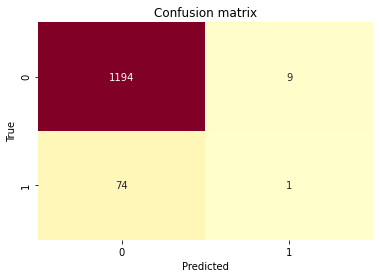

In [28]:
confusion_matrix2(BaggingClassifier(), X_train, y_train, X_test, y_test)

I picked up one model and looked at its confusion matrix. Model got 1% accuracy on actually positive data. But its total accuracy is 93.5% because the dataset is imbalanced. In this situation, can we say that this model is working well?
In my opinion, it is not. Let me remind you that the purpose of medical prediction is to find people with disease. What's the point of examination if it cannot detect disease?
The point is, relying on accuracy isn't very trustworthy in this case. 

$$recall = \frac{TP}{FN + TP}$$

Since the purpose of the is to find people who actually had stroke, recall score should be considered more importantly.

In [29]:
scores = {}

for ind, mod in enumerate(models):
    mod.fit(X_train, y_train)
    y_pred = mod.predict(X_test)
    score = cross_val_score(mod, X_train, y_train, scoring='recall', cv=5)
    scores[model_names[ind]] = score

results = pd.DataFrame(scores).T
results['mean'] = results.mean(1)

result_df = results.sort_values(by='mean', ascending=False)
result_df

,0,1,2,3,4,mean
XGBoost,0.057143,0.028571,0.058824,0.057143,0.142857,0.068908
LightGBM,0.057143,0.028571,0.088235,0.057143,0.085714,0.063361
Extra Trees,0.057143,0.057143,0.058824,0.114286,0.028571,0.063193
Bagging Classifier,0.028571,0.057143,0.088235,0.085714,0.028571,0.057647
Random Forest,0.057143,0.000000,0.058824,0.000000,0.028571,0.028908
Gradient Boosting,0.057143,0.000000,0.058824,0.000000,0.028571,0.028908
AdaBoost,0.057143,0.000000,0.000000,0.057143,0.000000,0.022857
K Nearest Neighbour,0.000000,0.000000,0.000000,0.057143,0.028571,0.017143
Gaussian Process,0.028571,0.057143,0.000000,0.000000,0.000000,0.017143
Logistic Regression,0.000000,0.028571,0.000000,0.000000,0.000000,0.005714


The result is disastrous.

In [30]:
scores = {}

ftwo_scorer = make_scorer(fbeta_score, beta=2)

for ind, mod in enumerate(models):
    mod.fit(X_train, y_train)
    y_pred = mod.predict(X_test)
    acc = cross_val_score(mod, X_train, y_train, scoring=ftwo_scorer, cv=5)
    scores[model_names[ind]] = acc

results = pd.DataFrame(scores).T
results['mean'] = results.mean(1)

result_df = results.sort_values(by='mean', ascending=False)
result_df.head(12)

,0,1,2,3,4,mean
Bagging Classifier,0.032895,0.068027,0.233333,0.067568,0.068493,0.094063
XGBoost,0.066225,0.034483,0.068493,0.067568,0.163399,0.080033
Extra Trees,0.068966,0.034483,0.105634,0.101351,0.066667,0.075420
LightGBM,0.067568,0.035211,0.102041,0.068966,0.099338,0.074625
Random Forest,0.034965,0.000000,0.071942,0.069444,0.034965,0.042263
Gradient Boosting,0.067568,0.000000,0.070922,0.000000,0.034965,0.034691
AdaBoost,0.069444,0.000000,0.000000,0.070423,0.000000,0.027973
K Nearest Neighbour,0.000000,0.000000,0.000000,0.069930,0.035211,0.021028
Gaussian Process,0.034483,0.068493,0.000000,0.000000,0.000000,0.020595
Logistic Regression,0.000000,0.035211,0.000000,0.000000,0.000000,0.007042


$$F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall }{(1 + \beta^2) precision + recall}$$

F beta score, or F2 score, can be used when you want to put more weight on precision or recall over other. $\beta = 2$ is commonly used when you prioritize recall over precision.

### Sampling Strategies

We should also talk about sampling methodology. Previously, model cannot because the number of positive data was relatively small.
To overcome the imbalance of data, we should over/undersample certain data to match the number.

In [31]:
def pr_auc_score(clf, x, y):
    precisions, recalls, _ = precision_recall_curve(y, clf.predict_proba(x)[:,1], pos_label=1)
    return auc(recalls, precisions)

In [32]:
def imbalanced_cross_validation_score(clf, x, y, cv, scoring, sampler):
    cv_score = 0.
    train_score = 0.
    test_score = 0.
    
    skf = StratifiedKFold(n_splits=cv, random_state=0, shuffle=True)
    
    for train_idx, test_idx in skf.split(x,y):
        
        xfold_train_sampled, yfold_train_sampled = sampler.fit_resample(x[train_idx, :],y[train_idx]) # when x is an array
        #xfold_train_sampled, yfold_train_sampled = sampler.fit_resample(x.iloc[train_idx, :],y[train_idx]) # when x is a dataframe
        clf.fit(xfold_train_sampled, yfold_train_sampled)
        
        train_score = scoring(clf, xfold_train_sampled, yfold_train_sampled)
        test_score  = scoring(clf, x[test_idx, :], y[test_idx]) # when x is an array
        #test_score  = scoring(clf, x.iloc[test_idx, :], y[test_idx]) # when x is a dataframe

        cv_score += test_score
        
    return cv_score/cv

In [33]:
def cv_scores_by_models(models, x, y, cv, scoring, sampler):
    scores = {}

    for ind, mod in enumerate(models):
        scores[model_names[ind]] = imbalanced_cross_validation_score(mod, x, y, cv, scoring, sampler)

    results = pd.DataFrame(scores, index=[f'{sampler}_score']).T.sort_values(by=f'{sampler}_score', ascending=False).reset_index().rename({'index':'classifier'}, axis=1)
    return results

#### Oversampling

In [34]:
smote = cv_scores_by_models(models, X_train, y_train, 5, pr_auc_score, SMOTE(random_state=1))

In [35]:
adasyn = cv_scores_by_models(models, X_train, y_train, 5, pr_auc_score, ADASYN(random_state=1))

In [36]:
randomoversampler = cv_scores_by_models(models, X_train, y_train, 5, pr_auc_score, RandomOverSampler(random_state=1))

#### UnderSampling

In [37]:
randomundersampler = cv_scores_by_models(models, X_train, y_train, 5, pr_auc_score, RandomUnderSampler(random_state=1))

In [38]:
tomeklinks = cv_scores_by_models(models, X_train, y_train, 5, pr_auc_score, TomekLinks())

In [39]:
clustercentroids = cv_scores_by_models(models, X_train, y_train, 5, pr_auc_score, ClusterCentroids(random_state=1))

#### Combined sampling

In [40]:
smotetomek = cv_scores_by_models(models, X_train, y_train, 5, pr_auc_score, SMOTETomek(random_state=1))

In [41]:
sampler_score_list = [smote, adasyn, randomoversampler, randomundersampler, tomeklinks, clustercentroids, smotetomek]
sampler_score_df = pd.DataFrame()
for i in range(len(sampler_score_list)):
    if i == 0:
        sampler_score_df = sampler_score_list[i]
    else:
        sampler_score_df = sampler_score_df.merge(sampler_score_list[i], how='left', on='classifier')
        
sampler_score_df.style.background_gradient(cmap='YlOrRd', vmin=0.05, vmax=0.5)

,classifier,SMOTE(random_state=1)_score,ADASYN(random_state=1)_score,RandomOverSampler(random_state=1)_score,RandomUnderSampler(random_state=1)_score,TomekLinks()_score,ClusterCentroids(random_state=1)_score,SMOTETomek(random_state=1)_score
0,Logistic Regression,0.164256,0.165365,0.173548,0.161029,0.174254,0.136895,0.163658
1,K Nearest Neighbour,0.158067,0.145801,0.141588,0.164174,0.113757,0.073632,0.161811
2,Gradient Boosting,0.138624,0.137919,0.179863,0.177683,0.182762,0.177463,0.148839
3,LightGBM,0.137488,0.115829,0.152090,0.155932,0.163653,0.157540,0.117773
4,AdaBoost,0.137378,0.134822,0.165472,0.119477,0.163100,0.112744,0.134481
5,SVC,0.123287,0.117543,0.128920,0.150933,0.114861,0.137766,0.123291
6,Random Forest,0.117863,0.112439,0.160371,0.162147,0.171766,0.173430,0.125212
7,XGBoost,0.112139,0.111552,0.139711,0.147795,0.159249,0.151208,0.122803
8,Bagging Classifier,0.111255,0.096399,0.123383,0.216606,0.168148,0.325977,0.093501
9,Gaussian Process,0.111040,0.114518,0.108589,0.117109,0.113416,0.097262,0.110024


There is one combination that stood up: using Cluster Centroids as sampling method and Bagging Classifier as an algorithm.

Let's see if we can improve the score by tuning hyperparameters.

In [42]:
Counter(y_train)

Counter({0: 3658, 1: 174})

In [43]:
sampler = ClusterCentroids()
X, y = sampler.fit_resample(X_train, y_train)
Counter(y)

Counter({0: 174, 1: 174})

In [44]:
bag = BaggingClassifier()
score = {}
for num in np.linspace(0.1, 1, 10):
    score[num] = imbalanced_cross_validation_score(bag, X_train, y_train, 5, pr_auc_score, 
                                                   ClusterCentroids(sampling_strategy=num, 
                                                                    random_state=1, 
                                                                    n_jobs=-1))

In [45]:
result = pd.DataFrame(score, index=['score']).T.reset_index().rename({'index':'sampling_strategy'}, axis=1)
best_sampling = result['sampling_strategy'][result['score'].idxmax()]
result.style.background_gradient(subset='score', cmap='YlOrRd', vmin=0, vmax=0.5)

,sampling_strategy,score
0,0.100000,0.131622
1,0.200000,0.110472
2,0.300000,0.124528
3,0.400000,0.158509
4,0.500000,0.178179
5,0.600000,0.191309
6,0.700000,0.246244
7,0.800000,0.248634
8,0.900000,0.306593
9,1.000000,0.318705


In [46]:
best_params, best_score = 0, 0

n_estimators = np.logspace(1, 2, 3, dtype=int)
max_samples = [0.9, 0.95, 1]
max_features = [1, 0.95, 0.9, 0.85, 0.8]

for n_estimator in n_estimators:
    for max_sample in max_samples:
        for max_feature in max_features:
            bag_params = {'n_estimators': n_estimator, 
                          'max_samples': max_sample,
                          'max_features': max_feature}
            bag = BaggingClassifier(**bag_params)
            
            score = imbalanced_cross_validation_score(bag, X_train, y_train, 5, pr_auc_score, 
                                                      ClusterCentroids(sampling_strategy=best_sampling,
                                                                       random_state=1, 
                                                                       n_jobs=-1))
            if score > best_score:
                best_params, best_score = bag_params, score
                print(f'Best score updated: {score}, {bag_params}')
            
print(best_score, best_params)

Best score updated: 0.13571770044129985, {'n_estimators': 10, 'max_samples': 0.9, 'max_features': 1}
Best score updated: 0.26630118464863045, {'n_estimators': 10, 'max_samples': 0.9, 'max_features': 0.95}
Best score updated: 0.2849001359357562, {'n_estimators': 10, 'max_samples': 0.9, 'max_features': 0.9}
Best score updated: 0.2938851572588848, {'n_estimators': 10, 'max_samples': 0.95, 'max_features': 0.95}
Best score updated: 0.5227034902522798, {'n_estimators': 10, 'max_samples': 1, 'max_features': 1}
0.5227034902522798 {'n_estimators': 10, 'max_samples': 1, 'max_features': 1}


## Prediction: test data from original distribution

#### Training model without undersampled data

Accuracy: 0.9381846635367762
Precision: 0.3333333333333333
Recall: 0.05333333333333334
F1-Score: 0.09195402298850575
F2-Score: 0.06410256410256411


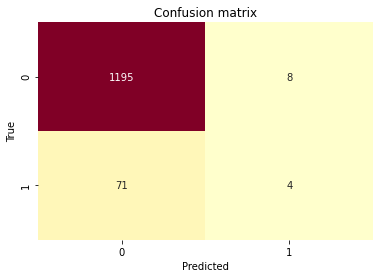

In [47]:
clf = BaggingClassifier()


confusion_matrix2(clf, X_train, y_train, X_test, y_test)

#### Training model with undersampled data

Accuracy: 0.7824726134585289
Precision: 0.1605351170568562
Recall: 0.64
F1-Score: 0.25668449197860965
F2-Score: 0.4006677796327212


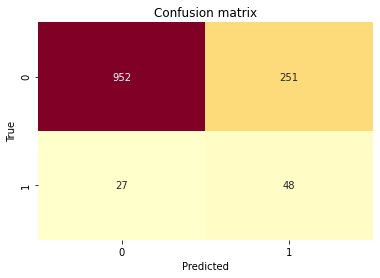

In [51]:
sampler = ClusterCentroids(random_state=1)
X, y = sampler.fit_resample(X_train, y_train)
clf = BaggingClassifier()


confusion_matrix2(clf, X, y, X_test, y_test)

#### Training model with undersampled data (hyperparameters tuned)

Accuracy: 0.05868544600938967
Precision: 0.05868544600938967
Recall: 1.0
F1-Score: 0.11086474501108647
F2-Score: 0.2376425855513308


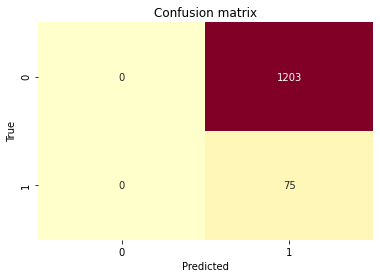

In [53]:
sampler = ClusterCentroids(sampling_strategy=best_sampling, random_state=1, n_jobs=-1)
X, y = sampler.fit_resample(X_train, y_train)
clf = BaggingClassifier(**best_params)


confusion_matrix2(clf, X, y, X_test, y_test)